# Imports

In [1]:
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import time
import gurobipy as gp
from collections import deque
# import seaborn as sns
# import pandas as pd
from tabulate import tabulate

# DAG functions

## Binary reachability

In [2]:
def binary_reachability(adj_list):
    """Returns a 2D array where P[i][j] = 1 if there is a path from i to j, else 0."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))

    def dfs(i, j):
        if P[i][j] == 1:
            return
        P[i][j] = 1
        for child in adj_list[j]:
            dfs(i, child)

    for i in range(num_nodes):
        dfs(i, i)

    return P

## Normalized Path Count

In [3]:
def normalized_path_count(adj_list):
    """Returns a 2D array where P[i][j] is the fraction of paths from i to j."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))

    def count_paths(i, j, memo):
        if i == j:
            return 1
        if i in memo and j in memo[i]:
            return memo[i][j]
        
        # Initialize i in memo if not exists
        memo.setdefault(i, {})

        paths = sum(count_paths(child, j, memo) for child in adj_list[i])
        memo[i][j] = paths
        return paths

    for i in range(num_nodes):
        memo = {}
        total_paths = sum(count_paths(i, k, memo) for k in range(num_nodes))
        if total_paths > 0:
            for j in range(num_nodes):
                P[i][j] = count_paths(i, j, memo) / total_paths

    return P

## Inverse Shortest Path

In [4]:
def inverse_shortest_path(adj_list):
    """Returns a 2D array where P[i][j] = 1/d(i, j), with d(i, j) as the shortest path length."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        queue = deque([(i, 0)])
        visited = set()

        while queue:
            node, dist = queue.popleft()
            if node in visited:
                continue
            visited.add(node)
            if node != i:
                P[i][node] = 1 / (dist + 1)

            for child in adj_list[node]:
                queue.append((child, dist + 1))

    return P

## Decay factor Over Distance

In [5]:
def decay_factor_over_distance(adj_list, lambda_=0.5):
    """Returns a 2D array where P[i][j] = e^(-lambda * d(i, j))."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        queue = deque([(i, 0)])
        visited = set()

        while queue:
            node, dist = queue.popleft()
            if node in visited:
                continue
            visited.add(node)
            if node != i:
                P[i][node] = np.exp(-lambda_ * dist)

            for child in adj_list[node]:
                queue.append((child, dist + 1))

    return P

## Weighted Path Contribution

In [6]:
def weighted_path_contribution(adj_list):
    """Returns a 2D array where P[i][j] is the sum of 1/d(i,j) over all paths from i to j."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))

    def dfs(i, j, depth):
        if i == j:
            return 1 / max(1, depth)
        return sum(dfs(child, j, depth + 1) for child in adj_list[i])

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                P[i][j] = dfs(i, j, 0)

    return P

## Heat Diffusion Model

In [7]:
def heat_diffusion_model(adj_list):
    """Returns a 2D array where P[i][j] follows a heat diffusion model: e^(-d(i,j))."""
    return decay_factor_over_distance(adj_list, lambda_=1.0)

## Random Walk Influence

In [8]:
def random_walk_influence(adj_list, lambda_=0.85):
    """Returns a 2D array where P[i][j] represents influence spread through a random walk."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))

    def walk(i, j, prob):
        if i == j:
            return prob
        if not adj_list[i]:
            return 0
        spread = prob * lambda_ / len(adj_list[i])
        return sum(walk(child, j, spread) for child in adj_list[i])

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                P[i][j] = walk(i, j, 1)

    return P

## Eigenvector Centrality

In [9]:
def eigenvector_centrality_influence(adj_list):
    """Returns a 2D array where P[i][j] is based on eigenvector centrality of nodes."""
    num_nodes = len(adj_list)
    A = np.zeros((num_nodes, num_nodes))

    for i, children in enumerate(adj_list):
        for child in children:
            A[i][child] = 1

    eigenvalues, eigenvectors = np.linalg.eig(A)
    centrality = np.abs(eigenvectors[:, np.argmax(eigenvalues.real)])

    P = np.outer(centrality, centrality) / np.max(np.outer(centrality, centrality))
    return P

# Cybersecurity Models

## Cybsec_L

In [10]:
def cybsec_l(c, d, p, q, V, r, budget, g):
    num_nodes = len(d)
    num_safeguards = len(q)
    num_levels = len(c[0])
    implemented_safeguards = np.full((num_nodes, num_safeguards, num_levels), False, dtype=bool)

    # Initialize Gurobi model
    model = Model("Minimize_Cost")
    
    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, lb=0, name="v")
    W = model.addVars(num_nodes, lb=0, name="W")
    Z = model.addVars(num_nodes, lb=0, name="Z")
    
    # Constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(sum(u[i, j, l] for l in range(num_levels)) == 1)
    
    for i in range(num_nodes):
        model.addConstr(sum(v[i, 0, l] for l in range(num_levels)) == V[i])
    
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])
    
    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(sum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == sum(v[i, j + 1, l] for l in range(num_levels)))
    
    for i in range(num_nodes):
        model.addConstr(W[i] == sum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))
    
    # Budget constraint
    model.addConstr(sum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)
    
    # Propagation constraint
    for i in range(num_nodes):
        propagated_vulnerability = sum(g[h][i] * W[h] for h in range(num_nodes) if g[h][i] > 0)
        model.addConstr(Z[i] >= propagated_vulnerability + W[i])
    
    # Objective function
    model.setObjective(
        sum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) +
        sum(p[i] * d[i] * Z[i] for i in range(num_nodes)), GRB.MINIMIZE
    )
    
    # Solve the problem
    model.optimize()

    print("Status:", model.Status)
    print("Final Decision Variables:")
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(1, num_levels):  # Skip l=0 since it's always 1 due to constraint
                if u[i, j, l].X > 0:
                    print(f"u[{i}][{j}][{l}] = {u[i, j, l].X}")
                    implemented_safeguards[i,j,l] = True
    
    final_safeguards = np.argwhere(implemented_safeguards)
    
    # Print results
    if model.status == GRB.OPTIMAL:
        print("Optimal Solution Found")
        cybersecurity_investment = sum(c[j][l] * u[i, j, l].x for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
        cybersecurity_gained = sum(p[i] * d[i] * V[i] * (1 - np.prod([sum(r[i][j][l_prime] * u[i, j, l_prime].x for l_prime in range(num_levels)) for j in range(num_safeguards) for l in range(num_levels)])) for i in range(num_nodes))
        cybersecurity_value = cybersecurity_gained - cybersecurity_investment
        cybersecurity_ratio = cybersecurity_gained / cybersecurity_investment if cybersecurity_investment > 0 else 0
        minimized_value = model.objVal
        print("Cybersecurity Investment:", cybersecurity_investment / 1000)
        print("Cybersecurity Value:", cybersecurity_value / 1000)
        print("Cybersecurity Ratio:", cybersecurity_ratio)
        print("Minimized Value of E:", minimized_value / 1000)
        print("Time taken for optimization (CPU seconds):", model.Runtime)
        print("Final Safeguards:")
        for i, j, l in final_safeguards:
            print((i + 1, j + 1, l))

        return cybersecurity_investment, cybersecurity_value, cybersecurity_ratio, minimized_value, final_safeguards, model.Runtime
    else:
        print("No optimal solution found.")
        return None, None, None, None, None, None

## Cybsec_BW

In [11]:
def cybsec_bw(c, q, V, r, budget, lambda_val, g):
    num_nodes = len(V)
    num_safeguards = len(q)
    num_levels = len(c[0])
    
    model = gp.Model("Minimize_Cost")
    
    # Decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.CONTINUOUS, lb=0, name="v")
    W = model.addVars(num_nodes, vtype=GRB.CONTINUOUS, lb=0, name="W")
    W_min = model.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name="W_min")
    W_max = model.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name="W_max")
    x = model.addVars(num_nodes, vtype=GRB.BINARY, name="x")
    Z = model.addVars(num_nodes, vtype=GRB.CONTINUOUS, lb=0, name="Z")
    
    # Constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(gp.quicksum(u[i, j, l] for l in range(num_levels)) == 1)
    
    for i in range(num_nodes):
        model.addConstr(gp.quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])
    
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])
    
    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(gp.quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) ==
                            gp.quicksum(v[i, j + 1, l] for l in range(num_levels)))
    
    for i in range(num_nodes):
        model.addConstr(W[i] == gp.quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))
    
    for i in range(num_nodes):
        model.addConstr(Z[i] == gp.quicksum(g[h][i] * W[h] for h in range(num_nodes)) + W[i])

    for i in range(num_nodes):
        model.addConstr(W_max >= Z[i])
        model.addConstr(W_min >= Z[i] - (1 - x[i]))
    
    model.addConstr(gp.quicksum(x[i] for i in range(num_nodes)) == 1)
    
    model.addConstr(gp.quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)
    
    model.setObjective((1 - lambda_val) * W_min + lambda_val * W_max, GRB.MINIMIZE)
    
    start_time = time.process_time()
    model.optimize()
    end_time = time.process_time()
    
    if model.status == GRB.OPTIMAL:
        print("Optimal solution found.")
    else:
        print("No optimal solution.")
        return None, None, None, None, None
    
    cybersecurity_investment = sum(c[j][l] * u[i, j, l].x for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
    minimized_value = model.objVal
    
    return cybersecurity_investment, W_min.x, W_max.x, minimized_value, end_time - start_time

## SCybsec_L(Pmax)

In [12]:
def scybsecl_pmax(c, d, p, q, V, r, budget, g):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize model
    model = Model("Minimize_Pmax")
    model.setParam('Threads', 12)
    
    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, lb=0, name="v")
    W = model.addVars(num_nodes, lb=0, name="W")
    Pmax = model.addVar(lb=0, name="Pmax")

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(quicksum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        model.addConstr(quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == quicksum(v[i, j + 1, l] for l in range(num_levels)))

    for i in range(num_nodes):
        model.addConstr(W[i] == quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))

    model.addConstr(quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)

    for i in range(num_nodes):
        model.addConstr(p[i] * W[i] + quicksum(g[h][i] * p[h] * W[h] for h in range(num_nodes)) <= Pmax)

    # Set objective
    model.setObjective(Pmax, GRB.MINIMIZE)

    # Start timer
    start_time = time.process_time()
    model.optimize()
    end_time = time.process_time()

    # Print the status
    if model.status == GRB.OPTIMAL:
        print("Optimal Solution Found")
    else:
        print("No Optimal Solution Found")
        return None, None, None, None, None, None, None

    cybersecurity_investment = sum(c[j][l] * u[i, j, l].X for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].X for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    breach_prob_per_node = [p[i] * W[i].X + sum(g[h][i] * p[h] * W[h].X for h in range(num_nodes)) for i in range(num_nodes)]
    exact_breach_prob_per_node = [ 1 - (1 - p[i] * W[i].X) * np.prod([(1 - g[h][i] * W[h].X) for h in range(num_nodes)]) for i in range(num_nodes)]
    minimized_value = model.ObjVal
    final_W_values =  [W[i].X for i in range(num_nodes)]

    print("Cybersecurity Investment:", cybersecurity_investment / 1000)
    print("Objective function:", minimized_value / 1000)
    print("Pmax:", Pmax.X)
    # print("Time taken for optimization (CPU seconds):", end_time - start_time)

    return cybersecurity_investment, minimized_value, Pmax.X, cybersecurity_investment_per_node, breach_prob_per_node, exact_breach_prob_per_node, final_W_values


## SCybsec_L(Lmax)

In [13]:
def scybsecl_lmax(c, d, p, q, V, r, budget, g):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize model
    model = Model("Minimize_Lmax")
    model.setParam('Threads', 12)
    
    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, lb=0, name="v")
    W = model.addVars(num_nodes, lb=0, name="W")
    Lmax = model.addVar(lb=0, name="Lmax")

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(quicksum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        model.addConstr(quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == quicksum(v[i, j + 1, l] for l in range(num_levels)))

    for i in range(num_nodes):
        model.addConstr(W[i] == quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))

    model.addConstr(quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)

    for i in range(num_nodes):
        model.addConstr(p[i] * W[i] + quicksum(g[h][i] * p[h] * W[h] for h in range(num_nodes)) <= Lmax * (1/d[i]))

    # Set objective
    model.setObjective(Lmax, GRB.MINIMIZE)

    # Start timer
    start_time = time.process_time()
    model.optimize()
    end_time = time.process_time()

    # Print the status
    if model.status == GRB.OPTIMAL:
        print("Optimal Solution Found")
    else:
        print("No Optimal Solution Found")
        return None, None, None, None, None, None, None

    cybersecurity_investment = sum(c[j][l] * u[i, j, l].X for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].X for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    breach_prob_per_node_1 = [p[i] * W[i].X + sum(g[h][i] * p[h] * W[h].X for h in range(num_nodes)) for i in range(num_nodes)]
    breach_prob_per_node = [d[i] * value for value in breach_prob_per_node_1]
    exact_breach_prob_per_node_1 = [ 1 - (1 - p[i] * W[i].X) * np.prod([(1 - g[h][i] * W[h].X) for h in range(num_nodes)]) for i in range(num_nodes)]
    exact_breach_prob_per_node = [d[i] * value for value in exact_breach_prob_per_node_1]
    minimized_value = model.ObjVal
    final_W_values =  [W[i].X for i in range(num_nodes)]

    print("Cybersecurity Investment:", cybersecurity_investment / 1000)
    print("Objective function:", minimized_value / 1000)
    print("Lmax:", Lmax.X)
    # print("Time taken for optimization (CPU seconds):", end_time - start_time)

    return cybersecurity_investment, minimized_value, Lmax.X, cybersecurity_investment_per_node, breach_prob_per_node, exact_breach_prob_per_node, final_W_values


## SCybsec_L(Qmin)

In [14]:
def scybsecl_qmin(c, d, p, q, V, r, budget, g):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize model
    model = Model("Maximize_Qmin")
    model.setParam('Threads', 12)
    
    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, lb=0, name="v")
    W = model.addVars(num_nodes, lb=0, name="W")
    Qmin = model.addVar(lb=0, name="Qmin")

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(quicksum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        model.addConstr(quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == quicksum(v[i, j + 1, l] for l in range(num_levels)))

    for i in range(num_nodes):
        model.addConstr(W[i] == quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))

    model.addConstr(quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)

    for i in range(num_nodes):
        model.addConstr(p[i] * W[i] + quicksum(g[h][i] * p[h] * W[h] for h in range(num_nodes)) <= 1 - Qmin)

    # Set objective
    model.setObjective(Qmin, GRB.MAXIMIZE)

    # Start timer
    # start_time = time.process_time()
    model.optimize()
    # end_time = time.process_time()

    # Print the status
    if model.status == GRB.OPTIMAL:
        print("Optimal Solution Found")
    else:
        print("No Optimal Solution Found")
        return None, None, None, None, None, None, None

    cybersecurity_investment = sum(c[j][l] * u[i, j, l].X for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].X for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    breach_prob_per_node_1 = [p[i] * W[i].X + sum(g[h][i] * p[h] * W[h].X for h in range(num_nodes)) for i in range(num_nodes)]
    breach_prob_per_node = [1 - value for value in breach_prob_per_node_1]
    exact_breach_prob_per_node = [(1 - p[i] * W[i].X) * np.prod([(1 - g[h][i] * W[h].X) for h in range(num_nodes)]) for i in range(num_nodes)]
    # exact_breach_prob_per_node = [d[i] * value for value in exact_breach_prob_per_node_1]
    maximized_value = model.ObjVal
    final_W_values =  [W[i].X for i in range(num_nodes)]

    print("Cybersecurity Investment:", cybersecurity_investment / 1000)
    print("Objective function:", maximized_value / 1000)
    print("Qmin:", Qmin.X)
    # print("Time taken for optimization (CPU seconds):", end_time - start_time)

    return cybersecurity_investment, maximized_value, Qmin.X, cybersecurity_investment_per_node, breach_prob_per_node, exact_breach_prob_per_node, final_W_values


## SCybsec_L(Smin)

In [15]:
def scybsecl_smin(c, d, p, q, V, r, budget, g):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize model
    model = Model("Maximize_Smin")
    model.setParam('Threads', 12)
    
    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, lb=0, name="v")
    W = model.addVars(num_nodes, lb=0, name="W")
    Smin = model.addVar(lb=0, name="Smin")

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(quicksum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        model.addConstr(quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == quicksum(v[i, j + 1, l] for l in range(num_levels)))

    for i in range(num_nodes):
        model.addConstr(W[i] == quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))

    model.addConstr(quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)

    for i in range(num_nodes):
        model.addConstr(p[i] * W[i] + quicksum(g[h][i] * p[h] * W[h] for h in range(num_nodes)) <= 1 - Smin * (1/d[i]))

    # Set objective
    model.setObjective(Smin, GRB.MAXIMIZE)

    # Start timer
    # start_time = time.process_time()
    model.optimize()
    # end_time = time.process_time()

    # Print the status
    if model.status == GRB.OPTIMAL:
        print("Optimal Solution Found")
    else:
        print("No Optimal Solution Found")
        return None, None, None, None, None, None, None

    cybersecurity_investment = sum(c[j][l] * u[i, j, l].X for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].X for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    breach_prob_per_node_1 = [p[i] * W[i].X + sum(g[h][i] * p[h] * W[h].X for h in range(num_nodes)) for i in range(num_nodes)]
    breach_prob_per_node = [d[i] * (1 - value) for value in breach_prob_per_node_1]
    exact_breach_prob_per_node_1 = [(1 - p[i] * W[i].X) * np.prod([(1 - g[h][i] * W[h].X) for h in range(num_nodes)]) for i in range(num_nodes)]
    exact_breach_prob_per_node = [d[i] * value for value in exact_breach_prob_per_node_1]
    maximized_value = model.ObjVal
    final_W_values =  [W[i].X for i in range(num_nodes)]

    print("Cybersecurity Investment:", cybersecurity_investment / 1000)
    print("Objective function:", maximized_value / 1000)
    print("Smin:", Smin.X)
    # print("Time taken for optimization (CPU seconds):", end_time - start_time)

    return cybersecurity_investment, maximized_value, Smin.X, cybersecurity_investment_per_node, breach_prob_per_node, exact_breach_prob_per_node, final_W_values


## Cyberport_SLP

## Cyberport_UBP

# Helper functions

## Calculate r_ijl = V_i ^ (e_j * c_jl)

In [16]:
def calculate_r(V, e, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(e)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for k in range(num_levels):
                r[i][j][k] = V[i] ** (e[j] * c[j][k])
    return r

## Scenario Probabilities for Cyberport_SLP and Cyberport_UBP

In [17]:
def calculate_scenario_probabilities(I, pi):
    num_scenarios = 2 ** len(I)
    scenario_probabilities = {}

    for s in range(num_scenarios):
        binary_representation = f"{s:0{len(I)}b}"
        Is = [int(bit) for bit in binary_representation]
        
        # Calculate Ps for scenario s
        Ps = 1
        for i in range(len(I)):
            if Is[i] == 1:
                Ps *= pi[i]
            else:
                Ps *= (1 - pi[i])
        
        scenario_probabilities[s] = Ps

    return scenario_probabilities

## Component Probabilities for Cyberport_SLP and Cyberport_UBP

In [18]:
def calculate_component_probabilities(K, S, pi, scenario_probabilities, aik):
    pk = [0] * len(K)

    for k in range(len(K)):
        for s, Ps in scenario_probabilities.items():
            # Check if scenario s has at least one threat that affects component k
            binary_representation = f"{s:0{len(pi)}b}"
            affects_k = any(aik[i][k] == 1 and int(binary_representation[i]) == 1 for i in range(len(pi)))
            
            if affects_k:
                pk[k] += Ps

    return pk

## Plotting for Cybsec_L

In [19]:


def plot_results_cybsec_l(g_options, g_option_names, budgets, results, num_safeguards, num_levels):
    """
    Plots investment, value, ratio, minimized value, and CPU time as bar plots.
    Displays:
    1. A table for implemented safeguards (node-by-node).
    2. A summary table for investment, value, ratio, minimized_value, and CPU time.
    """
    # Convert budgets to categorical strings (handle infinity)
    budget_labels = [str(b) if b != float('inf') else "∞" for b in budgets]

    # Extract values from results
    investment = results["cybsec_l"]["investment"]
    cybersecurity_value = results["cybsec_l"]["value"]
    cybersecurity_ratio = results["cybsec_l"]["ratio"]
    minimized_value = results["cybsec_l"]["minimized_value"]
    cpu_time = results["cybsec_l"]["cpu_time"]
    final_safeguards_raw = results["cybsec_l"]["final_safeguards"]  # Now storing implemented safeguards

    num_g = len(g_options)
    num_budgets = len(budgets)
    num_nodes = len(final_safeguards_raw[0])  # Assuming each entry has the same number of nodes

    # Ensure correct lengths
    expected_length = num_g * num_budgets
    if len(investment) != expected_length:
        raise ValueError(f"Investment size mismatch: Expected {expected_length}, got {len(investment)}")

    # **1. Create Table for Implemented Safeguards**
    # safeguards_table = []
    # for i, g_name in enumerate(g_option_names):
    #     for j, budget in enumerate(budget_labels):
    #         idx = j * num_g + i
    #         row = [g_name, budget]
            
    #         # Extract safeguards using np.argwhere
    #         implemented_safeguards = np.argwhere(final_safeguards_raw[idx])  # Shape: (x, 3) → (node, safeguard, level)
            
    #         safeguard_dict = {n: [] for n in range(num_nodes)}  # Dictionary to store per-node safeguards
            
    #         for node, safeguard, level in implemented_safeguards:
    #             safeguard_dict[node].append(f"S{safeguard+1}-L{level}")  # Format as S1-L1, S2-L2, etc.
            
    #         # Append to row (if no safeguards, mark as "None")
    #         for n in range(num_nodes):
    #             row.append(", ".join(safeguard_dict[n]) if safeguard_dict[n] else "None")
            
    #         safeguards_table.append(row)

    # # Create table headers
    # safeguards_headers = ["Graph", "Budget"] + [f"Node {n+1} Safeguards" for n in range(num_nodes)]

    # # Print formatted table for final safeguards
    # print("\n🔹 **Implemented Safeguards (Per-Node) Table** 🔹")
    # print(tabulate(safeguards_table, headers=safeguards_headers, tablefmt="grid", numalign="right"))

    # **2. Create Summary Table for Investment, Value, Ratio, Minimized Value, and CPU Time**
    summary_table = []
    for i, g_name in enumerate(g_option_names):
        for j, budget in enumerate(budget_labels):
            idx = j * num_g + i
            summary_table.append([
                g_name, budget, 
                f"{investment[idx]:.2f}", 
                f"{cybersecurity_value[idx]:.2f}", 
                f"{cybersecurity_ratio[idx]:.2f}", 
                f"{minimized_value[idx]:.2f}", 
                f"{cpu_time[idx]:.2f}"
            ])

    # Create table headers for summary table
    summary_headers = ["Graph", "Budget", "Investment", "Value", "Ratio", "Minimized Value", "CPU Time"]

    # Print formatted summary table
    print("\n🔹 **Summary Table: Investment, Value, Ratio, Minimized Value, and CPU Time** 🔹")
    print(tabulate(summary_table, headers=summary_headers, tablefmt="grid", numalign="right"))


    print(results["cybsec_l"]["final_safeguards"])

    # **2. Generate 5 Separate Bar Plots**
    metrics = {
        "Investment": investment,
        "Cybersecurity Value": cybersecurity_value,
        "Cybersecurity Ratio": cybersecurity_ratio,
        "Minimized Value": minimized_value,
        "CPU Time": cpu_time
    }

    x = np.arange(num_g)  # Graph indices for x-axis
    width = 0.15  # Bar width

    for metric_name, metric_values in metrics.items():
        plt.figure(figsize=(10, 6))
        
        for j, budget in enumerate(budget_labels):
            idx_start = j * num_g  # Index shift for each budget
            values = metric_values[idx_start:idx_start + num_g]
            plt.bar(x + j * width, values, width, label=f"Budget {budget}")

        plt.title(metric_name)
        plt.xticks(x + width * (num_budgets - 1) / 2, g_option_names, rotation=45)
        plt.ylabel(metric_name)
        plt.legend()
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        
        plt.tight_layout()
        plt.show()

## Plotting for Cybsec_BW

## Plotting for SCybsecL Models

In [20]:
def plot_results_scybsecl(g_options, g_option_names, budgets, results, algorithm, algorithm_name, objective_name, obj_func_name):
    """
    Plots investment, minimized value, and obj_func (pmax, lmax, qmin, or smin) as bar plots with categorical budget values.
    Displays:
    1. Per-node table (final_W_values, investment_per_node, breach_prob_per_node, exact_breach_prob_per_node)
    2. Summary table (investment, minimized_value, obj_func) against g and budget
    """
    # Convert budgets to categorical strings (handle infinity)
    budget_labels = [str(b) if b != float('inf') else "∞" for b in budgets]

    # Extract 1D lists from results
    investment = results[algorithm]["investment"]
    minimized_value = results[algorithm]["minimized_value"]
    obj_func = results[algorithm][obj_func_name]  # Generalized (pmax, lmax, qmin, smin)
    
    num_g = len(g_options)
    num_budgets = len(budgets)

    # Ensure correct lengths
    expected_length = num_g * num_budgets
    if len(investment) != expected_length:
        raise ValueError(f"Investment size mismatch: Expected {expected_length}, got {len(investment)}")
    if len(minimized_value) != expected_length:
        raise ValueError(f"Minimized value size mismatch: Expected {expected_length}, got {len(minimized_value)}")
    if len(obj_func) != expected_length:
        raise ValueError(f"{obj_func_name} size mismatch: Expected {expected_length}, got {len(obj_func)}")

    # Bar plot settings
    width = 0.15  # Bar width
    gap = 0.5  # Space between budget groups
    x_positions = np.arange(len(budgets)) * (num_g * width + gap)  # Add space between budget groups

    def plot_bar(values, title, ylabel):
        plt.figure(figsize=(12, 8))  # Wider plots
        for i, g_name in enumerate(g_option_names):
            plt.bar(
                x_positions + (i - len(g_options) / 2) * width, 
                [values[j * num_g + i] for j in range(num_budgets)], 
                width=width, label=g_name
            )
        plt.xlabel("Budget")
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xticks(x_positions, budget_labels)  # Position x-ticks at budget groups
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    # **1. Investment Plot**
    plot_bar(investment, f"Investment vs Budget for {algorithm_name}", "Investment")

    # **2. Minimized Value Plot**
    plot_bar(minimized_value, f"Minimized Value vs Budget for {algorithm_name}", "Minimized Value")

    # **3. Objective Function (pmax/lmax/qmin/smin) Plot**
    plot_bar(obj_func, f"{objective_name} vs Budget", f"{objective_name}")

    # **4. Create Table for Per-Node Values**
    investment_per_node = results[algorithm]["investment_per_node"]
    breach_prob_per_node = results[algorithm]["breach_prob_per_node"]
    exact_breach_prob_per_node = results[algorithm]["exact_breach_prob_per_node"]
    final_W_values = results[algorithm]["final_W_values"]

    num_nodes = len(investment_per_node[0])  # Assuming each entry has the same number of nodes

    # Create structured table data
    table_data = []
    for i, g_name in enumerate(g_option_names):
        for j, budget in enumerate(budget_labels):
            idx = j * num_g + i
            row = [g_name, budget]
            
            # Add values per node as separate columns
            for n in range(num_nodes):
                row.append(f"{final_W_values[idx][n]:.2f}")
                row.append(f"{investment_per_node[idx][n]:.2f}")
                row.append(f"{breach_prob_per_node[idx][n]:.3f}")
                row.append(f"{exact_breach_prob_per_node[idx][n]:.3f}")
            
            table_data.append(row)

    # Create table headers
    headers = ["Graph", "Budget"]
    for n in range(num_nodes):
        headers.extend([f"W (N{n+1})", f"Invest (N{n+1})", f"Br. Prob (N{n+1})", f"Ex. Br. Prob (N{n+1})"])

    # Print formatted per-node table
    print("\n🔹 **Per-Node Values Table** 🔹")
    print(tabulate(table_data, headers=headers, tablefmt="grid", numalign="right"))

    # **5. Create Summary Table for Investment, Minimized Value, and Obj Func**
    summary_table = []
    for i, g_name in enumerate(g_option_names):
        for j, budget in enumerate(budget_labels):
            idx = j * num_g + i
            summary_table.append([
                g_name, budget, 
                f"{investment[idx]:.2f}", 
                f"{minimized_value[idx]:.2f}", 
                f"{obj_func[idx]:.2f}"
            ])

    # Create table headers for summary table
    summary_headers = ["Graph", "Budget", "Investment", "Minimized Value", f"{objective_name}"]

    # Print formatted summary table
    print("\n🔹 **Summary Table: Investment, Minimized Value, and Objective Function** 🔹")
    print(tabulate(summary_table, headers=summary_headers, tablefmt="grid", numalign="right"))


## Print 2D list

In [21]:
# Print results
def print_2d_list(title, array):
    print(title)
    for row in array:  # Convert to list before iterating
        print(row)
    print()  # Blank line for spacing

# Implementation

## Data

In [33]:
# i = supply chain node, i in I, |I| = 10
# j = security safeguard, j in J, |J| = 20
# l = implementation level (0, light, medium, strong) = [0,1,2,3], l in L, |L| = 4

I = 10
J = 20
L = 4

# c_jl = investment cost for security safeguard j implemented at level l
c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(J)]

# e_j = efficiency level of safeguard j
e_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
e = [value * 1e-5 for value in e_temp]

# p_i = probability of cyberattack on node i
p = [0.35, 0.40, 0.35, 0.25, 0.40, 0.25, 0.55, 0.55, 0.75, 0.75]

# d_i = cost of loss due to breach of node i
d_temp = [450, 1500, 550, 300, 1200, 350, 2500, 2500, 10000, 10000]
d = [value * 1000 for value in d_temp]

# V_i = intrinsic vulnerability of node i
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]

# r_ijl = vulnerability reduction factor for node i secured by safeguard j implemented at level l
r = calculate_r(V, e, c)

# graph of supply chain nodes i
# adjacency list
children = [[3],
    [3,4,5],
    [5],
    [6],
    [6,7],
    [7],
    [8,9],
    [8,9],
    [],
    []]

# h_parents = reverse(children)
h_parents = [[],
    [],
    [],
    [0,1],
    [1],
    [1,2],
    [3,4],
    [4,5],
    [6,7],
    [6,7]]

# q = scaling factor for graph influence
# q = 1/len(c_light_temp)**2
q = 1/len(c_light_temp)
# q = 1

# g[a][b] =  influece of node a (parent) on node b. It is an ixi matrix

# Compute propagation coefficients using each method
g_binary_temp = binary_reachability(children).tolist()
g_path_count_temp = normalized_path_count(children).tolist()
g_inverse_temp = inverse_shortest_path(children).tolist()
g_decay_temp = decay_factor_over_distance(children, lambda_=0.5).tolist()
g_weighted_path_temp = weighted_path_contribution(children).tolist()
g_heat_temp = heat_diffusion_model(children).tolist()
g_random_walk_temp = random_walk_influence(children, lambda_=0.85).tolist()
g_eigenvector_temp = eigenvector_centrality_influence(children).tolist()

g_binary = [[q * value for value in row]  for row in g_binary_temp]
g_path_count = [[q * value for value in row]  for row in g_path_count_temp]
g_inverse = [[q * value for value in row]  for row in g_inverse_temp]
g_decay = [[q * value for value in row]  for row in g_decay_temp]
g_weighted_path = [[q * value for value in row]  for row in g_weighted_path_temp]
g_heat = [[q * value for value in row]  for row in g_heat_temp]
g_random_walk = [[q * value for value in row]  for row in g_random_walk_temp]
g_eigenvector = [[q * value for value in row]  for row in g_eigenvector_temp]

g_unconnected = [[0 for _ in range(I)] for _ in range(I)]
# print(g_unconnected)

# g_options = [g_unconnected, g_binary, g_path_count, g_inverse, g_decay, g_weighted_path, g_heat, g_random_walk, g_eigenvector]
# g_option_names = ["Unconnected", "Binary Reachability", "Normalized Path Count", "Inverse Shortest Path", "Decay Factor Over Distance", "Weighted Path Contribution", "Heat Diffusion", "Random Walk", "Eigenvector Centrality"]

g_options = [g_unconnected, g_inverse, g_decay, g_heat, g_random_walk]
g_option_names = ["Unconnected", "Inverse Shortest Path", "Decay Factor Over Distance", "Heat Diffusion", "Random Walk"]

# budgets_temp = [500, 1000, 2500, 5000, 10000, 15000, float('inf')]
budgets_temp = [500, float('inf')]
budgets = [value*1000 if value != float('inf') else value for value in budgets_temp]

# for cybsec_bw
lambda_vals = [0, 0.25, 0.5, 0.75, 1]



In [34]:
print_2d_list("Binary Reachability:", g_binary)
print_2d_list("Normalized Path Count:", g_path_count)
print_2d_list("Inverse Shortest Path:", g_inverse)
print_2d_list("Decay Factor Over Distance:", g_decay)
print_2d_list("Weighted Path Contribution:", g_weighted_path)
print_2d_list("Heat Diffusion Model:", g_heat)
print_2d_list("Random Walk Influence:", g_random_walk)
print_2d_list("Eigenvector Centrality Influence:", g_eigenvector)


Binary Reachability:
[0.05, 0.0, 0.0, 0.05, 0.0, 0.0, 0.05, 0.0, 0.05, 0.05]
[0.0, 0.05, 0.0, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
[0.0, 0.0, 0.05, 0.0, 0.0, 0.05, 0.0, 0.05, 0.05, 0.05]
[0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.05, 0.0, 0.05, 0.05]
[0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.05, 0.05, 0.05, 0.05]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.05, 0.05, 0.05]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.05, 0.05]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.05]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05]

Normalized Path Count:
[0.010000000000000002, 0.0, 0.0, 0.010000000000000002, 0.0, 0.0, 0.010000000000000002, 0.0, 0.010000000000000002, 0.010000000000000002]
[0.0, 0.003125, 0.0, 0.003125, 0.003125, 0.003125, 0.00625, 0.00625, 0.0125, 0.0125]
[0.0, 0.0, 0.010000000000000002, 0.0, 0.0, 0.010000000000000002, 0.0, 0.010000000000000002, 0.010000000000000002, 0.010000000000000002]
[0.0, 0.0, 0.0, 0.0125, 0.0, 0.0, 0.0125, 0.0, 0.

## Collecting Results

In [35]:
# for budget in budgets:
#     for g in g_options:
        
#         cybersecurity_investment_1, cybersecurity_value_1, cybersecurity_ratio_1, minimized_value_1, final_safeguards_1, cpu_time_1 = cybsec_l(c, d, p, q, V, r, budget, g)
        
#         for lambda_val in lambda_vals:
#             cybersecurity_investment_2, W_min_2, W_max_2, minimized_value_2, cpu_time_2 = cybsec_bw(c, q, V, r, budget, lambda_val, g)
        
#         cybersecurity_investment_3, minimized_value_3, Pmax_3, cybersecurity_investment_per_node_3, breach_prob_per_node_3, exact_breach_prob_per_node_3, final_W_values_3 = scybsecl_pmax(c, d, p, q, V, r, budget, g)

#         cybersecurity_investment_4, minimized_value_4, Lmax_4, cybersecurity_investment_per_node_4, breach_prob_per_node_4, exact_breach_prob_per_node_4, final_W_values_4 = scybsecl_lmax(c, d, p, q, V, r, budget, g)

#         cybersecurity_investment_5, minimized_value_5, Qmin_5, cybersecurity_investment_per_node_5, breach_prob_per_node_5, exact_breach_prob_per_node_5, final_W_values_5 = scybsecl_qmin(c, d, p, q, V, r, budget, g)

#         cybersecurity_investment_6, minimized_value_6, Smin_6, cybersecurity_investment_per_node_6, breach_prob_per_node_6, exact_breach_prob_per_node_6, final_W_values_6 = scybsecl_smin(c, d, p, q, V, r, budget, g)

In [36]:
# Initialize storage dictionaries
results = {
    "cybsec_l": {
        "investment": [],
        "value": [],
        "ratio": [],
        "minimized_value": [],
        "final_safeguards": [],
        "cpu_time": [],
    },
    "cybsec_bw": {},  # 3D Dictionary (budget -> lambda_val -> values)
    "scybsecl_pmax": {
        "investment": [],
        "minimized_value": [],
        "pmax": [],
        "investment_per_node": [],
        "breach_prob_per_node": [],
        "exact_breach_prob_per_node": [],
        "final_W_values": [],
    },
    "scybsecl_lmax": {
        "investment": [],
        "minimized_value": [],
        "lmax": [],
        "investment_per_node": [],
        "breach_prob_per_node": [],
        "exact_breach_prob_per_node": [],
        "final_W_values": [],
    },
    "scybsecl_qmin": {
        "investment": [],
        "minimized_value": [],
        "qmin": [],
        "investment_per_node": [],
        "breach_prob_per_node": [],
        "exact_breach_prob_per_node": [],
        "final_W_values": [],
    },
    "scybsecl_smin": {
        "investment": [],
        "minimized_value": [],
        "smin": [],
        "investment_per_node": [],
        "breach_prob_per_node": [],
        "exact_breach_prob_per_node": [],
        "final_W_values": [],
    },
}


In [37]:
for budget in budgets:
    for i in range(len(g_options)):
        g = g_options[i]
        g_name = g_option_names[i]

        print("---------IMPORTANT----------")
        print(f"Budget: {budget}")
        print(f"Graph Algorithm: {g_name}")
        print(f"Optimizer: Cybsec_L")
        print("----------------------------")

        # cybsec_l results
        cybersecurity_investment_1, cybersecurity_value_1, cybersecurity_ratio_1, minimized_value_1, final_safeguards_1, cpu_time_1 = cybsec_l(c, d, p, e, V, r, budget, g)
        
        results["cybsec_l"]["investment"].append(cybersecurity_investment_1)
        results["cybsec_l"]["value"].append(cybersecurity_value_1)
        results["cybsec_l"]["ratio"].append(cybersecurity_ratio_1)
        results["cybsec_l"]["minimized_value"].append(minimized_value_1)
        results["cybsec_l"]["final_safeguards"].append(final_safeguards_1)
        results["cybsec_l"]["cpu_time"].append(cpu_time_1)
        
        # print("---------IMPORTANT----------")
        # print(f"Budget: {budget}")
        # print(f"Graph Algorithm: {g_name}")
        # print(f"Optimizer: Cybsec_BW")
        # print("----------------------------")

        # # Initialize 3D dictionary for cybsec_bw
        # if budget not in results["cybsec_bw"]:
        #     results["cybsec_bw"][budget] = {}

        # for lambda_val in lambda_vals:
        #     cybersecurity_investment_2, W_min_2, W_max_2, minimized_value_2, cpu_time_2 = cybsec_bw(c, e, V, r, budget, lambda_val, g)

        #     if lambda_val not in results["cybsec_bw"][budget]:
        #         results["cybsec_bw"][budget][lambda_val] = {
        #             "investment": [],
        #             "W_min": [],
        #             "W_max": [],
        #             "minimized_value": [],
        #             "cpu_time": [],
        #         }

        #     results["cybsec_bw"][budget][lambda_val]["investment"].append(cybersecurity_investment_2)
        #     results["cybsec_bw"][budget][lambda_val]["W_min"].append(W_min_2)
        #     results["cybsec_bw"][budget][lambda_val]["W_max"].append(W_max_2)
        #     results["cybsec_bw"][budget][lambda_val]["minimized_value"].append(minimized_value_2)
        #     results["cybsec_bw"][budget][lambda_val]["cpu_time"].append(cpu_time_2)

        print("---------IMPORTANT----------")
        print(f"Budget: {budget}")
        print(f"Graph Algorithm: {g_name}")
        print(f"Optimizer: SCybsecL_Pmax")
        print("----------------------------")

        # scybsecl_pmax results
        cybersecurity_investment_3, minimized_value_3, Pmax_3, cybersecurity_investment_per_node_3, breach_prob_per_node_3, exact_breach_prob_per_node_3, final_W_values_3 = scybsecl_pmax(c, d, p, e, V, r, budget, g)

        results["scybsecl_pmax"]["investment"].append(cybersecurity_investment_3)
        results["scybsecl_pmax"]["minimized_value"].append(minimized_value_3)
        results["scybsecl_pmax"]["pmax"].append(Pmax_3)
        results["scybsecl_pmax"]["investment_per_node"].append(cybersecurity_investment_per_node_3)
        results["scybsecl_pmax"]["breach_prob_per_node"].append(breach_prob_per_node_3)
        results["scybsecl_pmax"]["exact_breach_prob_per_node"].append(exact_breach_prob_per_node_3)
        results["scybsecl_pmax"]["final_W_values"].append(final_W_values_3)

        print("---------IMPORTANT----------")
        print(f"Budget: {budget}")
        print(f"Graph Algorithm: {g_name}")
        print(f"Optimizer: SCybsecL_Lmax")
        print("----------------------------")

        # scybsecl_lmax results
        cybersecurity_investment_4, minimized_value_4, Lmax_4, cybersecurity_investment_per_node_4, breach_prob_per_node_4, exact_breach_prob_per_node_4, final_W_values_4 = scybsecl_lmax(c, d, p, e, V, r, budget, g)

        results["scybsecl_lmax"]["investment"].append(cybersecurity_investment_4)
        results["scybsecl_lmax"]["minimized_value"].append(minimized_value_4)
        results["scybsecl_lmax"]["lmax"].append(Lmax_4)
        results["scybsecl_lmax"]["investment_per_node"].append(cybersecurity_investment_per_node_4)
        results["scybsecl_lmax"]["breach_prob_per_node"].append(breach_prob_per_node_4)
        results["scybsecl_lmax"]["exact_breach_prob_per_node"].append(exact_breach_prob_per_node_4)
        results["scybsecl_lmax"]["final_W_values"].append(final_W_values_4)

        print("---------IMPORTANT----------")
        print(f"Budget: {budget}")
        print(f"Graph Algorithm: {g_name}")
        print(f"Optimizer: SCybsecL_Qmin")
        print("----------------------------")

        # scybsecl_qmin results
        cybersecurity_investment_5, minimized_value_5, Qmin_5, cybersecurity_investment_per_node_5, breach_prob_per_node_5, exact_breach_prob_per_node_5, final_W_values_5 = scybsecl_qmin(c, d, p, e, V, r, budget, g)

        results["scybsecl_qmin"]["investment"].append(cybersecurity_investment_5)
        results["scybsecl_qmin"]["minimized_value"].append(minimized_value_5)
        results["scybsecl_qmin"]["qmin"].append(Qmin_5)
        results["scybsecl_qmin"]["investment_per_node"].append(cybersecurity_investment_per_node_5)
        results["scybsecl_qmin"]["breach_prob_per_node"].append(breach_prob_per_node_5)
        results["scybsecl_qmin"]["exact_breach_prob_per_node"].append(exact_breach_prob_per_node_5)
        results["scybsecl_qmin"]["final_W_values"].append(final_W_values_5)

        print("---------IMPORTANT----------")
        print(f"Budget: {budget}")
        print(f"Graph Algorithm: {g_name}")
        print(f"Optimizer: SCybsecL_Smin")
        print("----------------------------")

        # scybsecl_smin results
        cybersecurity_investment_6, minimized_value_6, Smin_6, cybersecurity_investment_per_node_6, breach_prob_per_node_6, exact_breach_prob_per_node_6, final_W_values_6 = scybsecl_smin(c, d, p, e, V, r, budget, g)

        results["scybsecl_smin"]["investment"].append(cybersecurity_investment_6)
        results["scybsecl_smin"]["minimized_value"].append(minimized_value_6)
        results["scybsecl_smin"]["smin"].append(Smin_6)
        results["scybsecl_smin"]["investment_per_node"].append(cybersecurity_investment_per_node_6)
        results["scybsecl_smin"]["breach_prob_per_node"].append(breach_prob_per_node_6)
        results["scybsecl_smin"]["exact_breach_prob_per_node"].append(exact_breach_prob_per_node_6)
        results["scybsecl_smin"]["final_W_values"].append(final_W_values_6)



---------IMPORTANT----------
Budget: 500000
Graph Algorithm: Unconnected
Optimizer: Cybsec_L
----------------------------
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Fedora Linux 41 (Workstation Edition)")

CPU model: AMD Ryzen 5 7430U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1221 rows, 1620 columns and 4630 nonzeros
Model fingerprint: 0x338c29af
Variable types: 820 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [1e-13, 6e+05]
  Objective range  [1e+04, 8e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 5e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 298 rows and 318 columns
Presolve time: 0.05s
Presolved: 923 rows, 1302 columns, 5463 nonzeros
Variable types: 720 continuous, 582 integer (582 binary)
Found heuristic solution: 

## Generating Plots


🔹 **Summary Table: Investment, Value, Ratio, Minimized Value, and CPU Time** 🔹
+----------------------------+----------+--------------+-------------+---------+-------------------+------------+
| Graph                      | Budget   |   Investment |       Value |   Ratio |   Minimized Value |   CPU Time |
+============================+==========+==============+=============+=========+===================+============+
| Unconnected                | 500000   |       500000 |   9.376e+06 |   19.75 |       1.34985e+07 |       8.09 |
+----------------------------+----------+--------------+-------------+---------+-------------------+------------+
| Unconnected                | ∞        |     4.05e+06 |  1.4181e+07 |     4.5 |       7.84851e+06 |       2.27 |
+----------------------------+----------+--------------+-------------+---------+-------------------+------------+
| Inverse Shortest Path      | 500000   |       500000 |  9.4594e+06 |   19.92 |       1.47153e+07 |      14.47 |
+-------

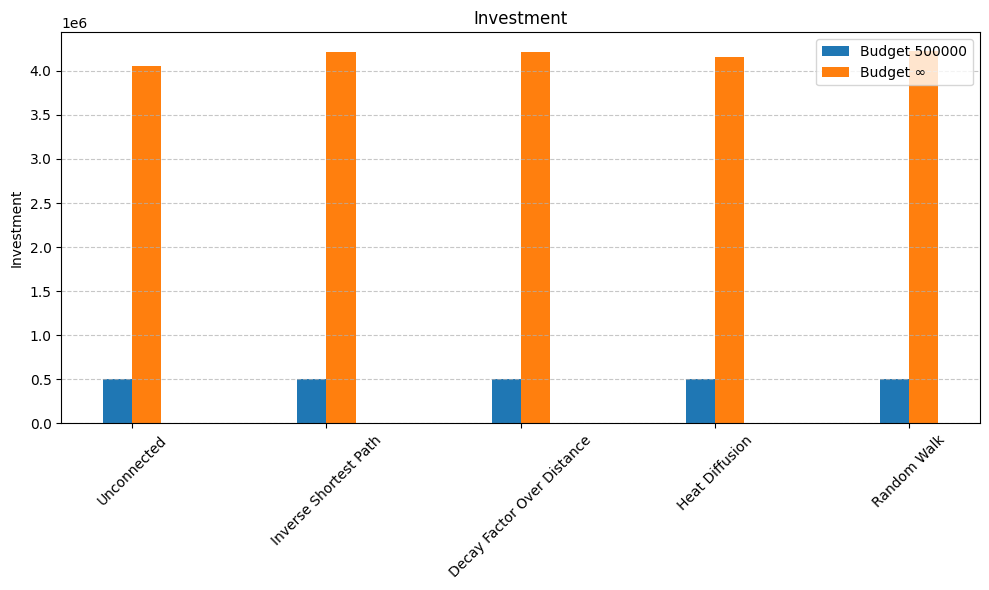

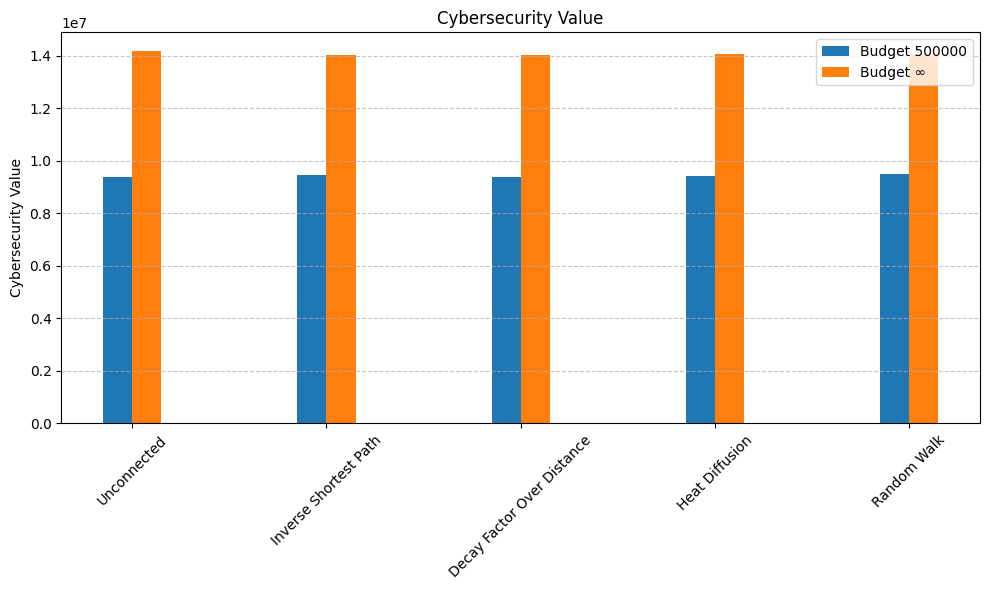

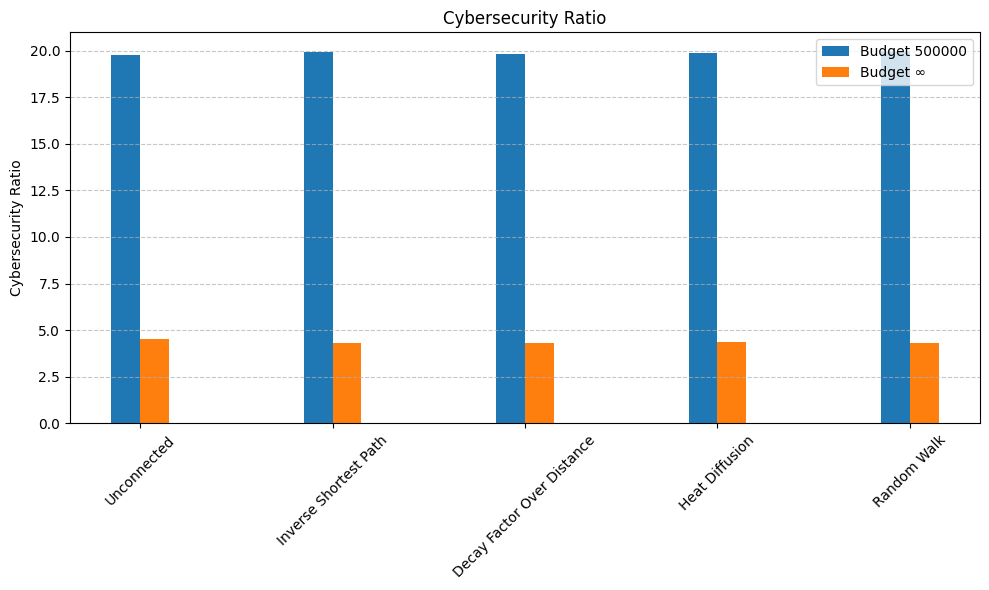

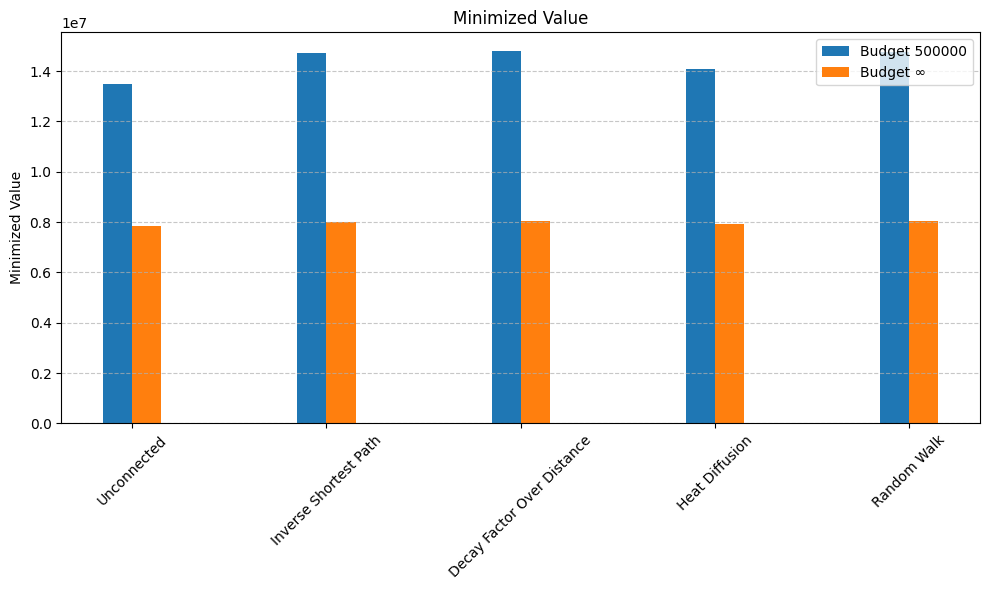

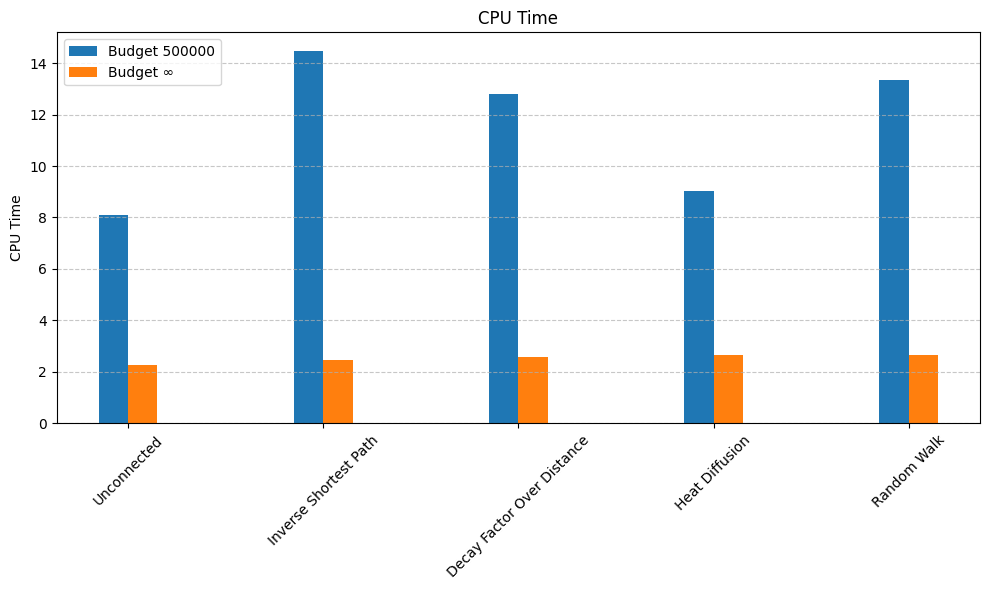

In [38]:
plot_results_cybsec_l(g_options, g_option_names, budgets, results, 20, 4)

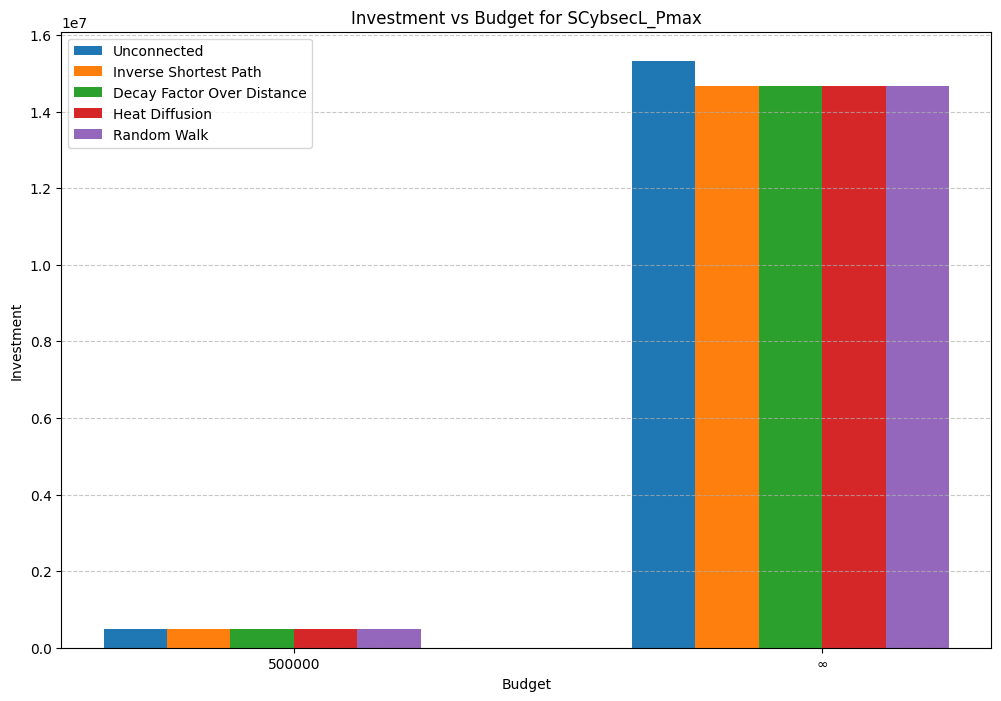

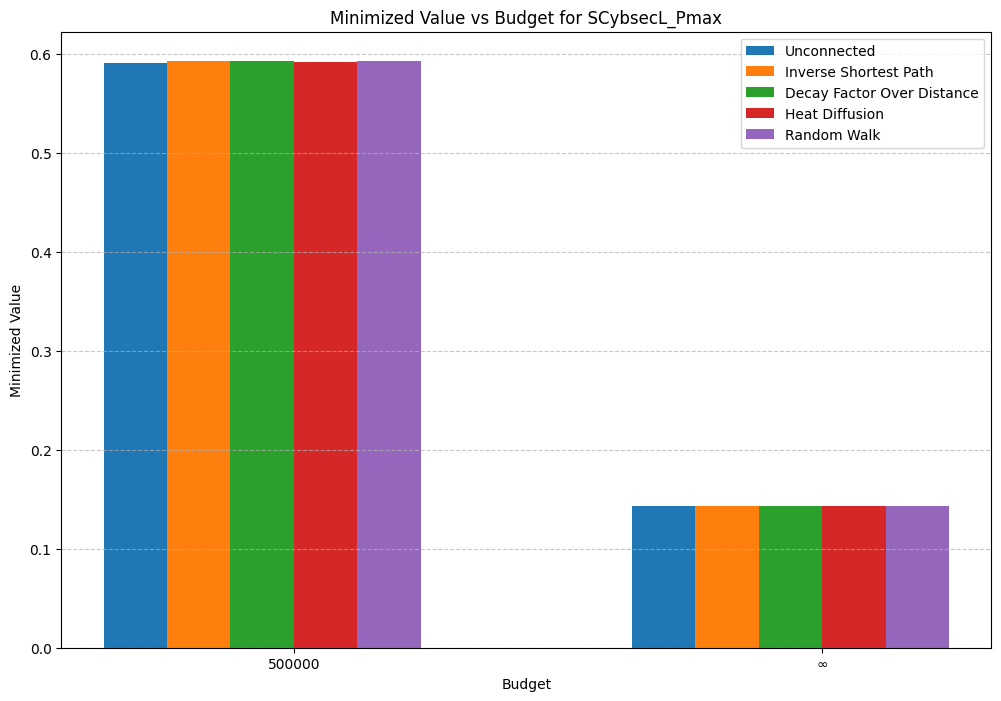

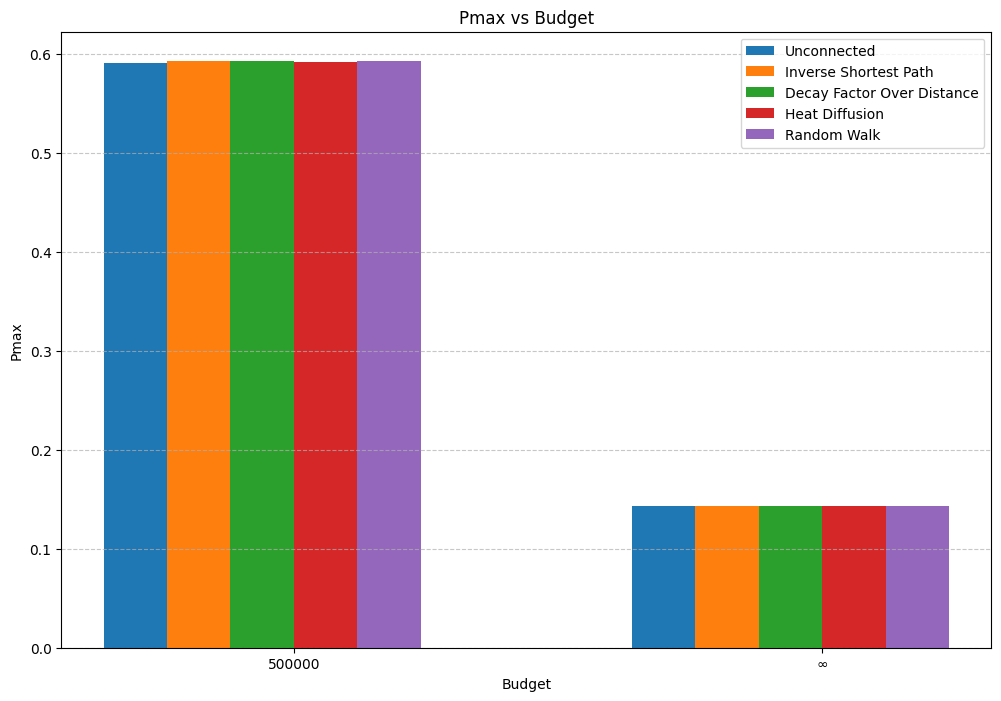


🔹 **Per-Node Values Table** 🔹
+----------------------------+----------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+-----------+----------------+------------------+----------------------+
| Graph                      | Budget   |   W (N1) |   Invest (N1) |   Br. Prob (N1) |   Ex. Br. Prob (N1) |   W (N2) |   Invest (N2) |   Br. Prob (N2) |   Ex. Br. Prob (N2) |   W (N3) |   Invest (N3) |   Br. Prob (N3) |   Ex. Br. Prob (N3) |   W (N4) |

In [29]:
plot_results_scybsecl(g_options, g_option_names, budgets, results, "scybsecl_pmax", "SCybsecL_Pmax", "Pmax", "pmax")


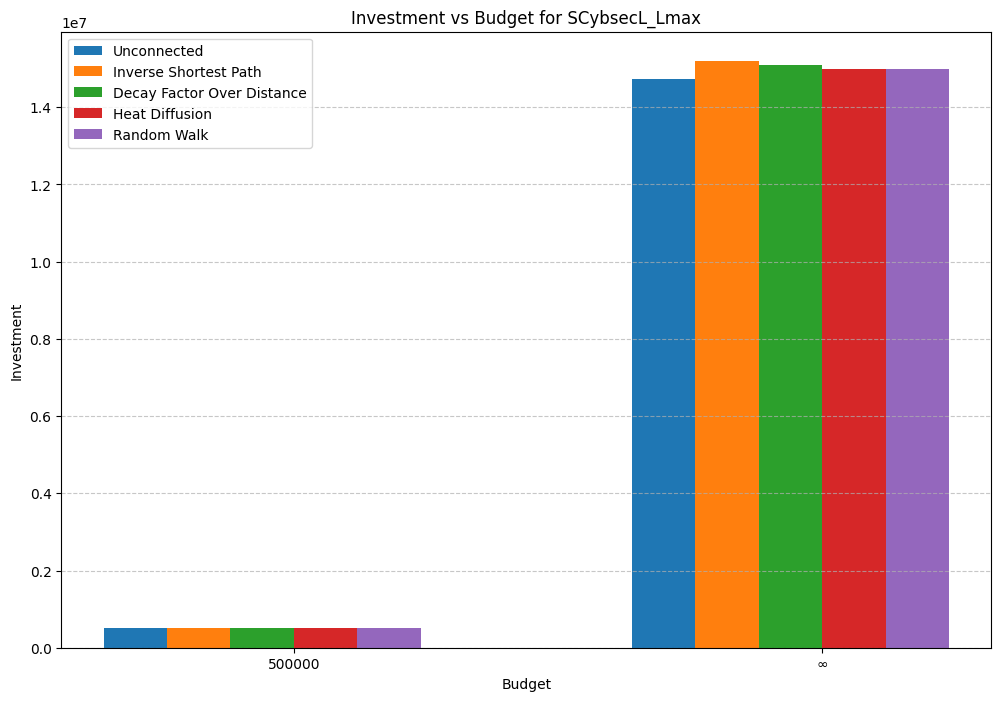

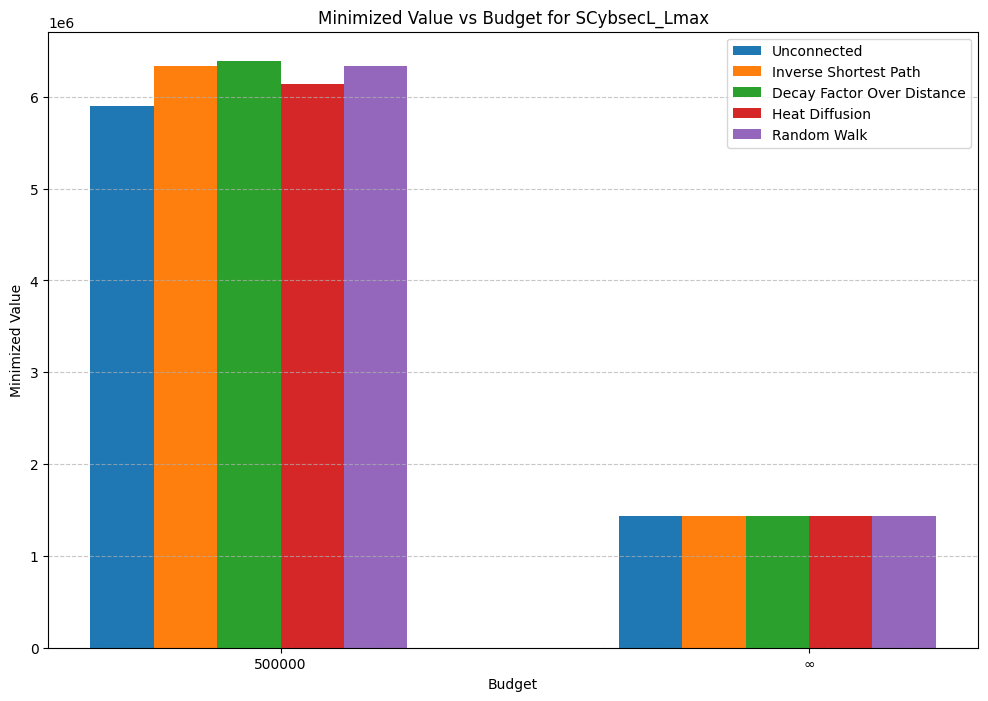

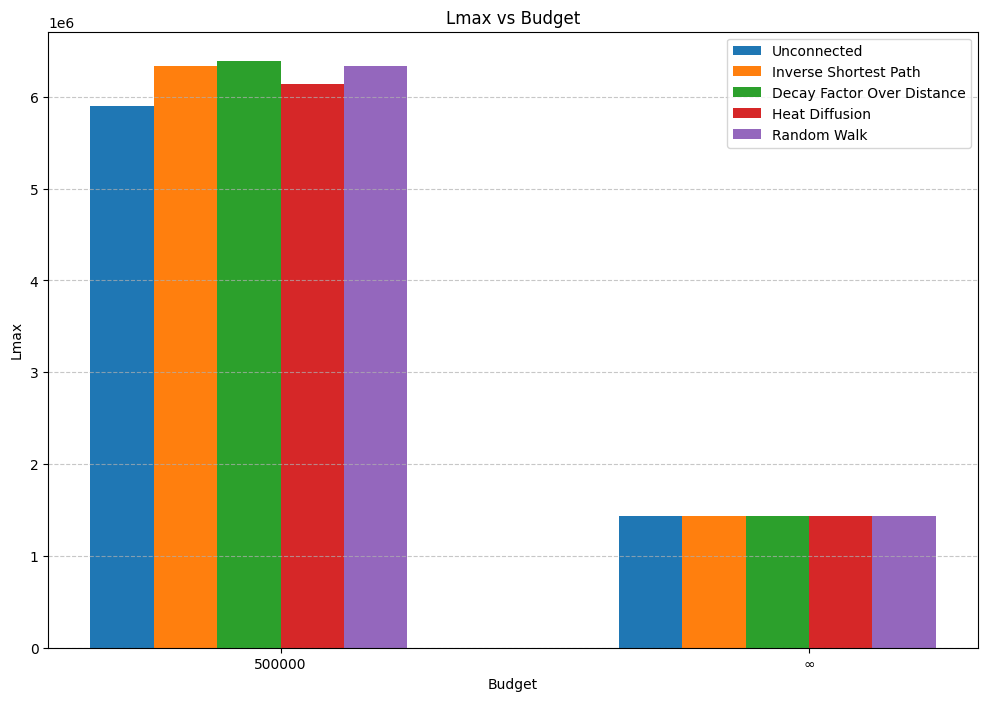


🔹 **Per-Node Values Table** 🔹
+----------------------------+----------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+-----------+----------------+------------------+----------------------+
| Graph                      | Budget   |   W (N1) |   Invest (N1) |   Br. Prob (N1) |   Ex. Br. Prob (N1) |   W (N2) |   Invest (N2) |   Br. Prob (N2) |   Ex. Br. Prob (N2) |   W (N3) |   Invest (N3) |   Br. Prob (N3) |   Ex. Br. Prob (N3) |   W (N4) |

In [39]:
plot_results_scybsecl(g_options, g_option_names, budgets, results, "scybsecl_lmax", "SCybsecL_Lmax", "Lmax", "lmax")

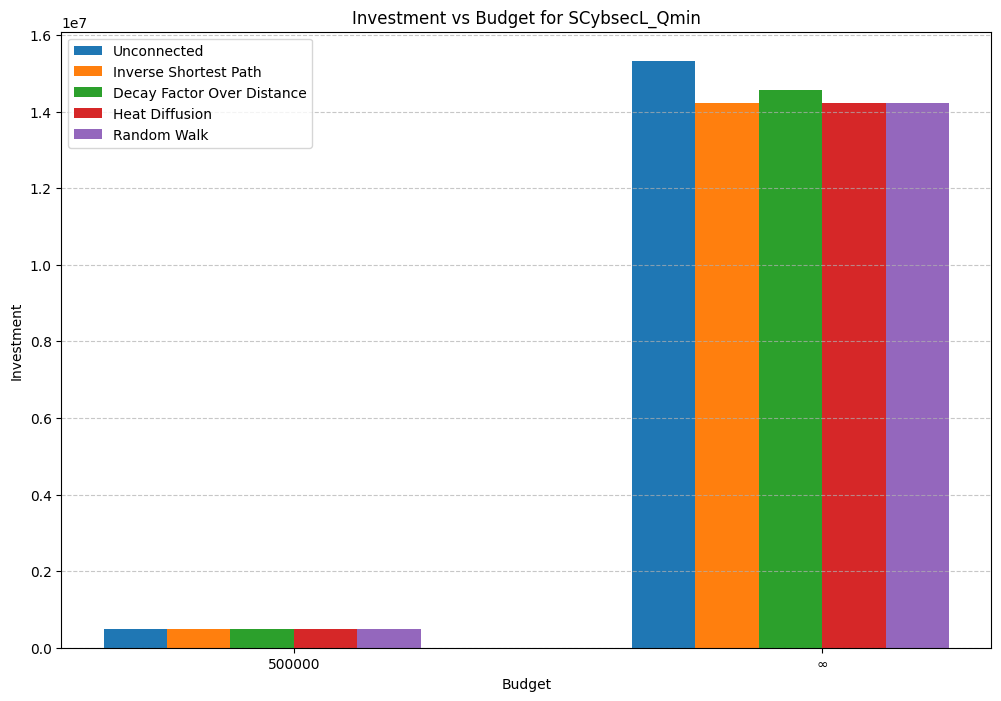

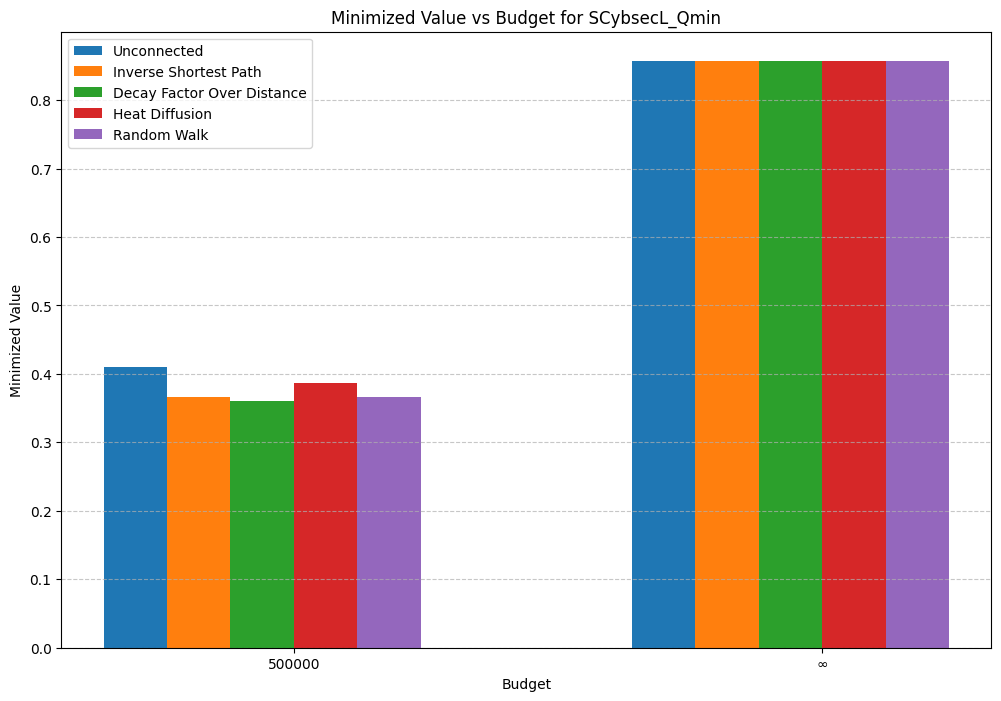

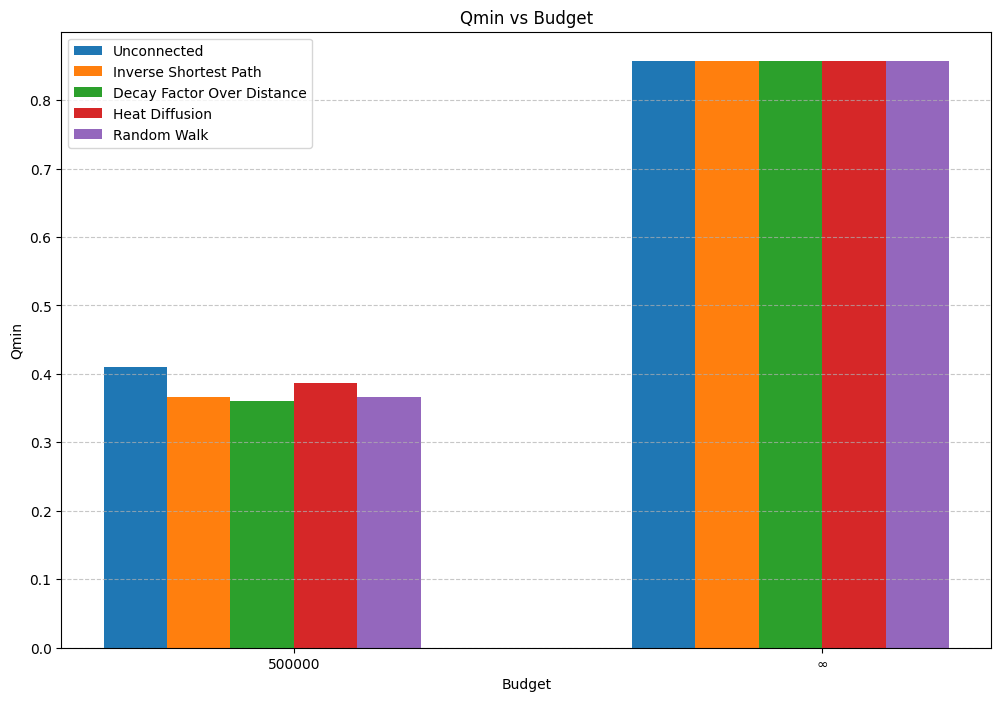


🔹 **Per-Node Values Table** 🔹
+----------------------------+----------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+-----------+----------------+------------------+----------------------+
| Graph                      | Budget   |   W (N1) |   Invest (N1) |   Br. Prob (N1) |   Ex. Br. Prob (N1) |   W (N2) |   Invest (N2) |   Br. Prob (N2) |   Ex. Br. Prob (N2) |   W (N3) |   Invest (N3) |   Br. Prob (N3) |   Ex. Br. Prob (N3) |   W (N4) |

In [40]:
plot_results_scybsecl(g_options, g_option_names, budgets, results, "scybsecl_qmin", "SCybsecL_Qmin", "Qmin", "qmin")

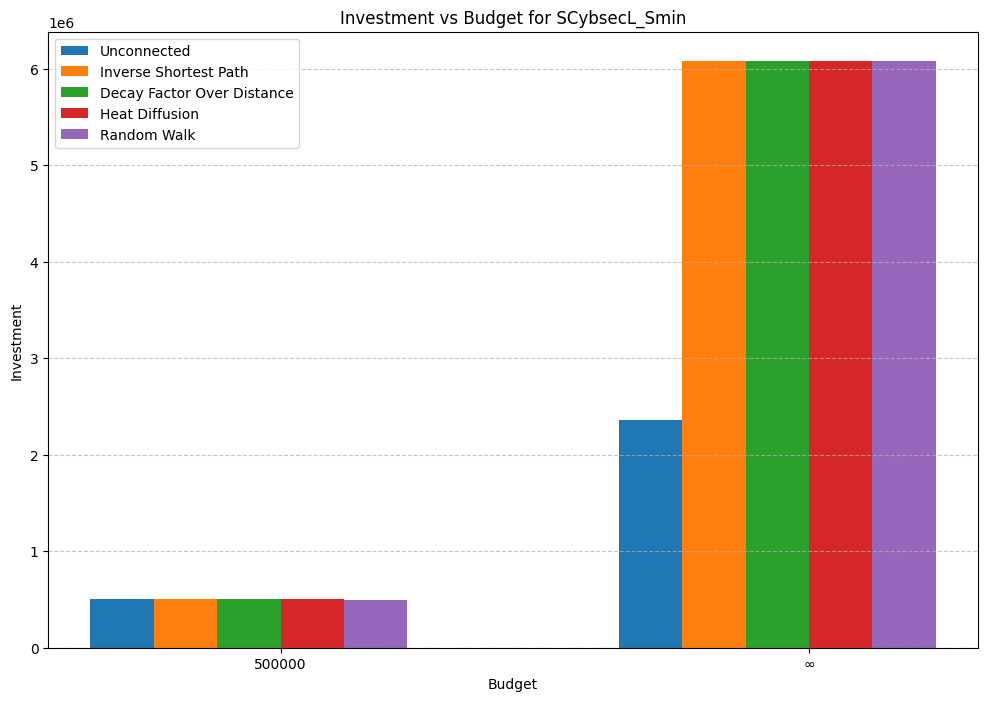

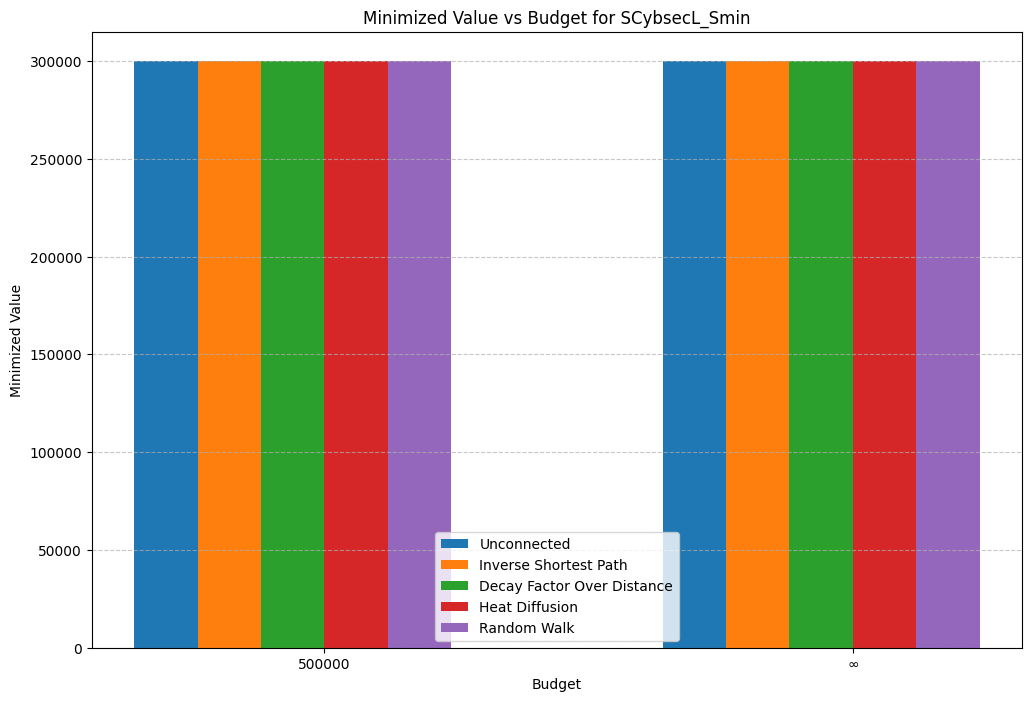

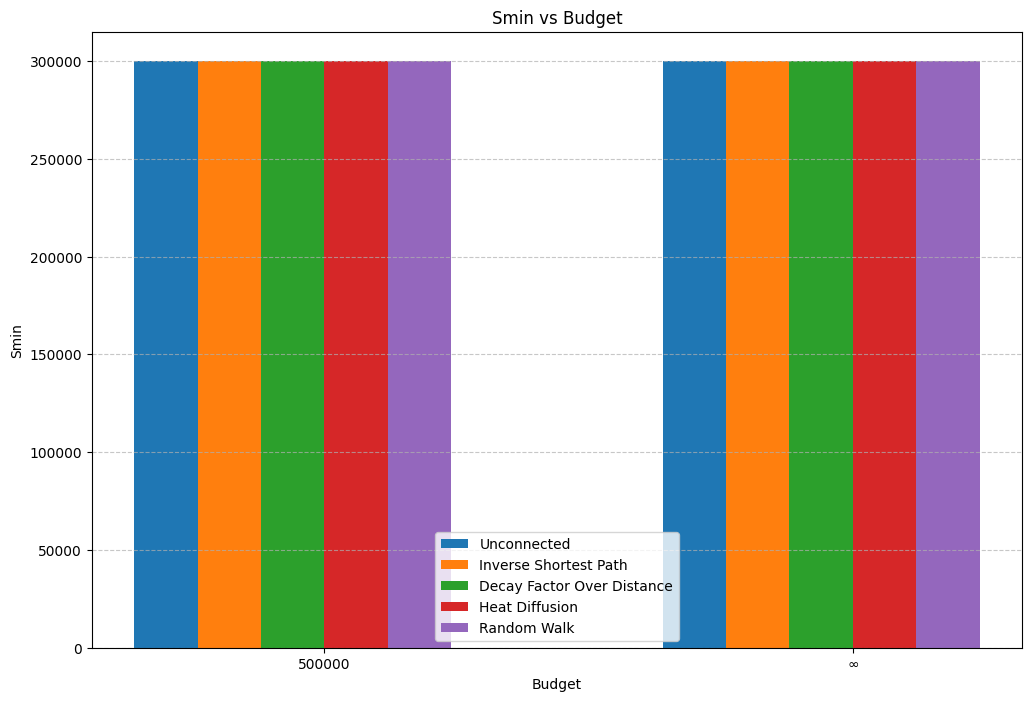


🔹 **Per-Node Values Table** 🔹
+----------------------------+----------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+-----------+----------------+------------------+----------------------+
| Graph                      | Budget   |   W (N1) |   Invest (N1) |   Br. Prob (N1) |   Ex. Br. Prob (N1) |   W (N2) |   Invest (N2) |   Br. Prob (N2) |   Ex. Br. Prob (N2) |   W (N3) |   Invest (N3) |   Br. Prob (N3) |   Ex. Br. Prob (N3) |   W (N4) |

In [41]:
plot_results_scybsecl(g_options, g_option_names, budgets, results, "scybsecl_smin", "SCybsecL_Smin", "Smin", "smin")